# Political Party Prediction via Tweet Replies: 
## “Τell me your replying tweet to tell you to what political party you are replying to”.

#### For this assignment you will use the tweets in the provided `gr_meps_tweets.csv` file. 
*_These are tweets made by Greek Members of the European Parliament (MEPs), monitored during a period of months. Along with the tweets from MEPs, tweets replying to them were also monitored and stored. This dataset is not publicly available and you are not allowed to distribute it by any means. Any processing of this dataset is explicitly limited to the scopes of the Practical Data Science course of the Data Science MSc in AUEB. For any other use, please contact Ioannis Pavlopoulos (annis@aueb.gr)._*

## Part I: The dataset

### a) [3 points] Load and complete the dataset
#### i. Read the dataset from the .csv file.

In [1]:
import pandas as pd
import tweepy
import numpy as np
from twitter_config import config
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
import pickle

In [2]:
# import the csv file in a dataframe parsing the dates
tweets = pd.read_csv('gr_meps_tweets.csv',index_col=[0],parse_dates=['created_at'])
tweets.head()

,tweet_id_str,in_reply_to_status_id,in_reply_to_user_id,retweet_count,favorite_count,created_at,lang,user_id,screen_name,is_mp,reply_to,party
0,1139889470294188032,NaN,NaN,10,60,2019-06-15 13:36:42,el,1,v_meimarakis,1,NaN,N.D
1,1139515527980883968,NaN,NaN,7,72,2019-06-14 12:50:47,el,1,v_meimarakis,1,NaN,N.D
2,1139589480661340160,1.139516e+18,3.992951e+09,0,0,2019-06-14 17:44:39,el,2,MedoF92837686,0,1.139516e+18,NaN
3,1139560707102511106,1.139516e+18,3.992951e+09,0,0,2019-06-14 15:50:19,el,3,Angelos6291,0,1.139516e+18,NaN
4,1139557430344519682,1.139516e+18,3.992951e+09,0,0,2019-06-14 15:37:18,in,4,MagdalenaMerz,0,1.139516e+18,NaN


#### ii. Download the text of each tweet with tweepy.
* Use the IDs (`tweet_id_str` column). 
* Save the texts to a new column named `downloaded_text` to the dataframe.
* WARNING: Do not be rate limited. You can lookup multiple statuses per call (download should be completed within minutes).

## Sources i used
* https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id
* https://stackoverflow.com/questions/48779575/twitter-api-rate-limit-issue

In [3]:
# importing the personal tokens from the tweeter developers account  
auth = tweepy.OAuthHandler(config['consumer_key'], config['consumer_secret'])
auth.set_access_token(config['access_token'], config['access_token_secret'])
# initialize the tweepy wrapper
api = tweepy.API(auth)

In [4]:
# initialization of variables for performance and in order to keep the content as soon the loop stops
counter = 0
tweet_id = []
tmp = []
# api.statuses_lookup gets on every call 100 tweets so we have to bunch the tweet_id_str in group of hundreds
# iterate over all the ids
for i in tweets['tweet_id_str']:
#   check if 100 have stored 
    if counter < 100:
#         append ids temporarily
        tmp.append(i)
#      increment the counter
        counter+=1
    else:
#       As soon 100 have collected store ids from temporary variable in a list.
#       The 'tweet_id' list has in every row a list of 100 tweets 
        tweet_id.append(tmp)
#     empty the temprorary variable for the next itteration 
        tmp =[]
#     append the the id from the current itteration 
        tmp.append(i)
#     increment the counter because on id has already stored
        counter = 1
#     in case the number of ids is not multiple of 100 store the last ids 
tweet_id.append(tmp)
        
data = []
# fetch all the tweets with statuses_lookup.tweet_mode='extended' downloads the whole tweet ,map_ download as none tweets tha dont exist
for i in range(len(tweet_id)):
        data.append(api.statuses_lookup(id_ = tweet_id[i],tweet_mode='extended',include_entities = True,map_ = True))

In [5]:
tw = []
# data variable is a list that every row has 100 tweets
# itterate over the rows of data variable.
for i in range(len(data)):
#   itterate over every tweet in a row 
    for j in range(len(data[i])):
        try:
#             get the text of every tweet and append it
            tw.append(data[i][j].full_text)
        except:
#             if there is no text or the tweet does not exist append NaN
            tw.append(None)
#  store the texts of tweets in the dataframe in a new column
tweets['downloaded_text'] = tw

#### iii. Discard records where the text could not be downloaded.

In [6]:
# locate where the downloaded text is NaN
tweets.loc[tweets.downloaded_text.isna()]

,tweet_id_str,in_reply_to_status_id,in_reply_to_user_id,retweet_count,favorite_count,created_at,lang,user_id,screen_name,is_mp,reply_to,party,downloaded_text
77,1140611788775612416,1.140609e+18,3.119513e+08,0,1,2019-06-17 13:26:56,el,37,59fpatra,0,1.140609e+18,NaN,None
99,1140536685924667392,1.140338e+18,3.119513e+08,0,1,2019-06-17 08:28:30,el,44,grekkguard,0,1.140338e+18,NaN,None
108,1140133973823299584,NaN,NaN,2,12,2019-06-16 05:48:16,el,32,GiorgosKyrtsos,1,NaN,N.D,None
109,1140132158146777089,NaN,NaN,82,326,2019-06-16 05:41:03,el,32,GiorgosKyrtsos,1,NaN,N.D,None
110,1140468426638598144,1.140132e+18,3.119513e+08,0,0,2019-06-17 03:57:16,el,50,georgetzuras,0,1.140132e+18,NaN,None
116,1140321264239808514,1.140132e+18,3.119513e+08,0,3,2019-06-16 18:12:30,el,56,baspap71,0,1.140132e+18,NaN,None
118,1140281730575867904,1.140132e+18,3.119513e+08,0,0,2019-06-16 15:35:24,el,58,gorgy,0,1.140132e+18,NaN,None
122,1140265302422368256,1.140132e+18,3.119513e+08,1,0,2019-06-16 14:30:07,und,33,Koulara555,0,1.140132e+18,NaN,None
130,1140196906083262465,1.140132e+18,3.119513e+08,1,12,2019-06-16 09:58:20,el,67,1964steri,0,1.140132e+18,NaN,None
134,1140190437757657088,1.140132e+18,3.119513e+08,0,7,2019-06-16 09:32:38,el,22,siderialexandra,0,1.140132e+18,NaN,None


In [7]:
# Delete every row where there is NaN cheking the column 'downloaded_text' from the original dataframe(inplace=True)  
tweets.dropna(how='any',subset=['downloaded_text'],inplace=True)

### b) [3 points] Dataset preparation
#### i. Change the index to `tweet_id_str`.


In [8]:
# change the index and apply it to the original dataframe
tweets.set_index('tweet_id_str',inplace=True)

#### ii. Get info from the parent tweets.
* Create a method `get_party_of_parent_mep(tweet_id=None)`which for a given tweet should be returning the party of its parent tweet (the tweet to which the given tweet is a reply) posted from a MEP user or np.nan if this is not possible (e.g., the given tweet is not a reply or the parent tweet is not included). Save the returned parties to a new `to_party` column.
* Create a method `get_screen_name_of_parent_mep(tweet_id=None)`, which for a given tweet should be returning the screen_name of the MEP of its parent tweet. Again, return np.nan if the given tweet is not a reply or the parent tweet is not included. Save the returned screen names to a new `to_mep` column.
* *Note that in both situations we are interested in only parent tweets posted from MEPs (replies to tweets of non MEPs should not be considered).* 


## Source i used
* https://stackoverflow.com/questions/6016744/nan-in-python-and-validity-checking

In [9]:
def get_party_of_parent_mep(tweet_id):
#   Check if the tweet_id has a non empty 'reply_to' column
    if np.isnan(tweets.loc[tweet_id].reply_to) == False:
        a = tweets.loc[tweet_id].reply_to
#       in case the parent tweet does not exist an error is raised 
        try:
#           Search for the parent tweet until an mep is reached (if any)(a reply can be a reply of someone who originaly replied to MEP)
            while tweets.loc[a].is_mp == 0:
                a = tweets.loc[a].reply_to
#           If the replied id has a parent id (exist in tweet_id_str column) return the party 
            return tweets.loc[a].party
            
        except:
#         else return none
            return np.nan
    else:
#         else return none
        return np.nan
        
def get_screen_name_of_parent_mep(tweet_id):
#   Check if the tweet_id has a non empty 'reply_to' column
    if np.isnan(tweets.loc[tweet_id].reply_to) == False:
        a = tweets.loc[tweet_id].reply_to
#         in case the parent tweet does not exist an error is raised 
        try:
#             Search for the parent tweet until an mep is reached (if any)
            while tweets.loc[a].is_mp == 0:
                a = tweets.loc[a].reply_to
#           If the replied id has a parent id (exist in tweet_id_str column) return the screen name
            return tweets.loc[a].screen_name
        except:
#       else return none
            return np.nan
#       else return none 
    else:
        return np.nan
# get the party  and store it in a column in dataframe 
tweets['to_party'] = [get_party_of_parent_mep(i) for i in tweets.index]
# get the name of MEP and store it in a column in dataframe
tweets['to_mep'] = [get_screen_name_of_parent_mep(j) for j in tweets.index]

#### iii. Remove from the dataset tweets that are not replies.

In [10]:
# locate the NaN values in rtply_to column
tweets.loc[tweets.reply_to.isna()]

,in_reply_to_status_id,in_reply_to_user_id,retweet_count,favorite_count,created_at,lang,user_id,screen_name,is_mp,reply_to,party,downloaded_text,to_party,to_mep
tweet_id_str,,,,,,,,,,,,,,
1139889470294188032,NaN,NaN,10,60,2019-06-15 13:36:42,el,1,v_meimarakis,1,NaN,N.D,@ZKaprali @AnnaAsimakopoul @kmitsotakis @EvaKa...,NaN,NaN
1139515527980883968,NaN,NaN,7,72,2019-06-14 12:50:47,el,1,v_meimarakis,1,NaN,N.D,@AnnaAsimakopoul @kmitsotakis Τώρα που μπήκε ε...,NaN,NaN
1139104280881876992,NaN,NaN,12,165,2019-06-13 09:36:38,el,1,v_meimarakis,1,NaN,N.D,Η μόνη κυβέρνηση στην Ε.Ε. που πήρε «πορτοφόλι...,NaN,NaN
1140614051229306881,NaN,NaN,3,13,2019-06-17 13:35:56,en,17,MariaSpyraki,1,NaN,N.D,Χρόνια Πολλά και Φωτισμένα στην Ελλάδα μας!\n#...,NaN,NaN
1140551004691279872,NaN,NaN,6,0,2019-06-17 09:25:24,el,17,MariaSpyraki,1,NaN,N.D,@GiorgosKyrtsos @anastassios2401 Ειναι αληθεια...,NaN,NaN
1140533890727206918,NaN,NaN,9,23,2019-06-17 08:17:24,und,17,MariaSpyraki,1,NaN,N.D,Η πολιτική δυναμική είναι με το μέρος του Μητσ...,NaN,NaN
1140530437183475712,NaN,NaN,4,0,2019-06-17 08:03:40,el,17,MariaSpyraki,1,NaN,N.D,- Είχα την τιμή να εισηγηθώ την πρόταση νόμου ...,NaN,NaN
1140264736384311296,NaN,NaN,15,0,2019-06-16 14:27:52,en,17,MariaSpyraki,1,NaN,N.D,RT @georgemilon: https://t.co/MjMBQ9acg1,NaN,NaN
1139973293774163968,NaN,NaN,5,0,2019-06-15 19:09:47,el,17,MariaSpyraki,1,NaN,N.D,"@v_meimarakis Καλα σε εβαλαν στον παγο ,ασε τι...",NaN,NaN


In [11]:
# Delete tweets that are not replies.
tweets.dropna(how='any',subset=['reply_to'],inplace = True)
# Delete tweets that are not replies to MEP
tweets.dropna(subset=['to_party'],inplace = True)

### c) [1 point] Exploratory analysis of the data

#### i. Use seaborn to visualise your data, with respect to the party the tweets are aimed to.
* Draw a barplot comparing the `favorite_count` (mean estimation) attribute per party.
* Do the same for the `retweet_count` attribute.
* Include 99% Confidence Intervals error bars on both of the above plots.
* Draw a countplot comparing the replies per party.


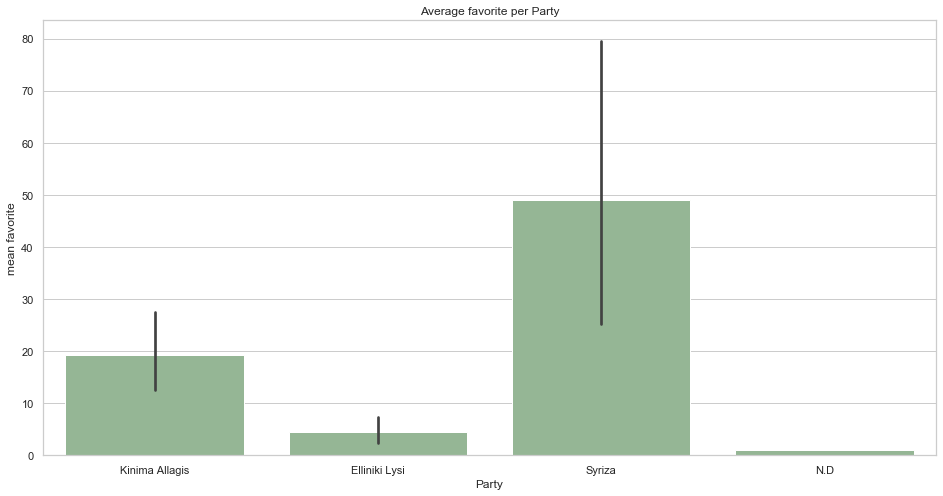

In [12]:
# set the background
sns.set(style="whitegrid")
# Set the size of the figure
plt.figure(figsize=(16, 8))
# Set the variable for x and y axes, consider 99% confidence interval and take the mean estimation
ax = sns.barplot(x="party", y="favorite_count",data=tweets,color='darkseagreen',ci= 99,estimator=np.mean)
# set title
ax.set_title('Average favorite per Party')
# set name in y axes
plt.ylabel('mean favorite')
# set name in x axes
plt.xlabel('Party')

plt.show()

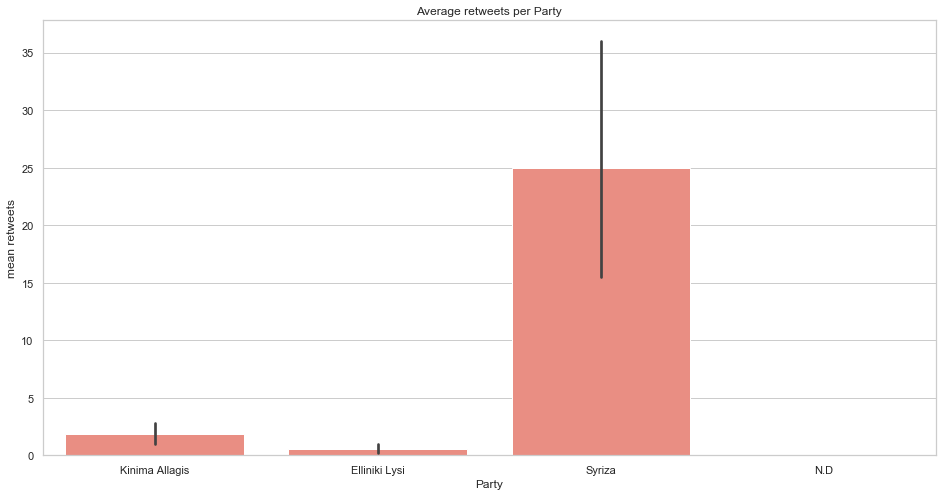

In [13]:
# set the background
sns.set(style="whitegrid")
# Set the size of the figure
plt.figure(figsize=(16, 8))
# Set the variable for x and y axes, consider 99% confidence interval and take the mean estimation
ax = sns.barplot(x="party", y="retweet_count",data=tweets,color='salmon',ci= 99,estimator=np.mean)
# set title
ax.set_title('Average retweets per Party')
# set name in y axes
plt.ylabel('mean retweets')
# set name in x axes
plt.xlabel('Party')
plt.show()

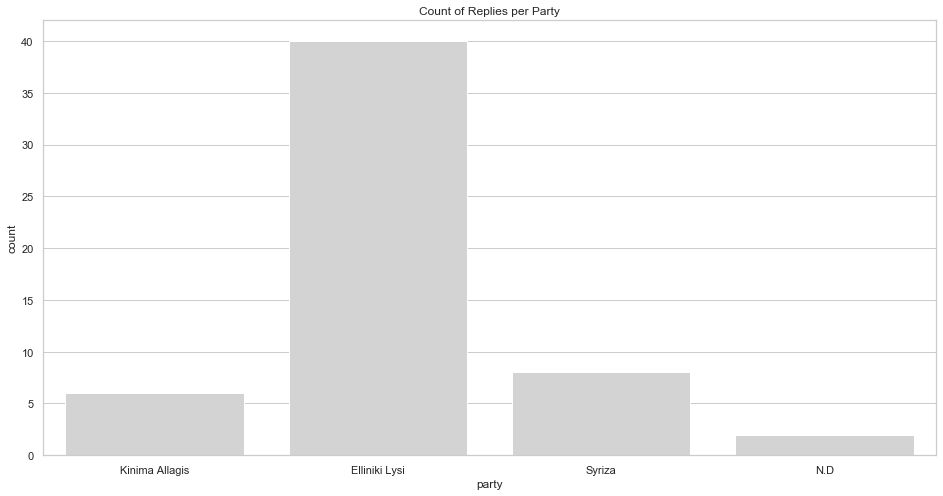

In [14]:
# set the background
sns.set(style="whitegrid")
# Set the size of the figure
plt.figure(figsize=(16, 8))
# set the variable party
ax = sns.countplot(x="party", data=tweets,color='lightgrey')
# set title name
ax.set_title('Count of Replies per Party')
plt.show()

## Part II: Algorithms
*_Use methods of sklearn for the next tasks._*

### a) [1 point] Pre-process the data

#### i. Split the data in train/test.
* Use a 90/10 split. 
* Use the `downloaded_tweets` data as X and the `to_party` data as y.

## Source i used
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [15]:
# split into train and test set.Use the whole dataframe as x and y in order to split it ramdomly 
train_x, test_x, train_y,test_y = train_test_split(tweets,tweets,test_size=0.1, random_state=1)
# from the whole datafame choose dowloaded_tweets as x and to_party as y
x_train = train_x.downloaded_text
x_test = test_x.downloaded_text
y_train = train_y.to_party
y_test = test_y.to_party

#### ii. Convert the train and test sets to matrices of TF-IDF features.
* Discard English stop words.
* Remove any words included in more than the 50% of the dataset or in less than 3 documents.

In [16]:
# set the tfidf vectorizer excluding english stop words, remove words that apear more than 50% or in less than 3 documents
vectorizer = TfidfVectorizer(stop_words="english",max_df=0.5,min_df =3)
# fit the train set(learn the vocabulary) and tranform in tf idf matrix 
X = vectorizer.fit_transform(x_train)
# tranform but DONT fit the test set
X_test = vectorizer.transform(x_test) 

### b) [5 points] Clustering

#### i. Use K-Means to cluster the tweets of the train set.
* Set 10 clusters.

In [17]:
# fit in train set k means clustering with 10 clusters
kmeans = KMeans(n_clusters=10).fit(X)

#### ii. Use K-Means to perform clustering per party.
* Create subsets of the train set for each party and perform K-Means on each subset.
* Tune k to find the optimum number of clusters per party. Use the Silhouette Coeff. and range k from 3 to 9.

In [18]:
# use dependent variable to locate the tweets of every party
# take the index of every party in dependant variable plug it in the independent variable and store it in a new variable for every party
x_train_nd = x_train[y_train.loc[y_train =='N.D'].index]
x_train_syriza = x_train[y_train[y_train =='Syriza'].index]
x_train_kinal = x_train[y_train[y_train =='Kinima Allagis'].index]
x_train_ell = x_train[y_train[y_train =='Elliniki Lysi'].index]

# vectorize every subset of the train set with the same parameters
vectorizer = TfidfVectorizer(stop_words="english",max_df=0.5,min_df =3)
# fit and transform the train subsets
x_nd = vectorizer.fit_transform(x_train_nd)
x_syriza = vectorizer.fit_transform(x_train_syriza)
x_kinal = vectorizer.fit_transform(x_train_kinal)
x_ell = vectorizer.fit_transform(x_train_ell)

# store the subsets in one variable 
train = [x_nd,x_syriza,x_kinal,x_ell]
# store the labels of each subset
label =['nd','syriza','kinima allagis','elliniki lysi']

## Source i used
* https://stackoverflow.com/questions/3989016/how-to-find-all-positions-of-the-maximum-value-in-a-list

In [19]:
# fuction that computes and return the shilouette score.Takes as inputs the estimator and the data
def shiloue(estimator,data):
#   fit the data in the data set
    estimator.fit(data)
#   compute and return the score
    return metrics.silhouette_score(data, estimator.labels_,metric='euclidean')
    
# iterate over the trainning data(every rowof 'train' variable has a dataframe coresponds to a party)        
for labe,tr in enumerate(train):
#   initialize a variable to store the shiloutte score for different k(clussters in k means)
    metric = []
#   iterate for k between 3 and 10
    for i in range(3,10):
#       call the shiloue function and append the score in a variable
        metric.append(shiloue(KMeans(init='k-means++',n_clusters=i),tr))
#   store the index of the max silhouette score
    index = metric.index(max(metric))
    print('for party:',label[labe],',k =',index+3,'max silhouette score is:',max(metric))

for party: nd ,k = 8 max silhouette score is: 0.03469275894043726
for party: syriza ,k = 3 max silhouette score is: 0.019460890473756237
for party: kinima allagis ,k = 9 max silhouette score is: 0.0940267680319565
for party: elliniki lysi ,k = 9 max silhouette score is: 0.026889955280981818


>Silhouette score for all parties is close to zero indicate overlapping clusters,an intuitive result considering that we take as input a tweet and try to predict from which party is the MEP that this tweet was a reply. A tweet can potentialy be a reply to multiple MEPs

### c) [4 points] Classification
* Train two algorithms to learn to classify an unseen (replying) tweet based on the political party it replies to.
* Use the train set to train them and the test set for prediction.

In [20]:
# retrive all the party names 
tags_occs = train_y.to_party.apply(lambda x: [i.lower() for i in [x]]).sum()
# keep the unique names
tags_list = list(set(tags_occs))

def get_onehot (tags, taglist=tags_list):
    # get the position of the tags in the list of tags
    tag_indices = {taglist.index(tag.lower()) for tag in [tags]}
    # form a list where True are indices of the positions of the tags
    hot_embedding = [int(tag_index in tag_indices) for tag_index in range(len(taglist))]
    return hot_embedding

# transform the dependent variable in one hot embedding and store it in a vector
Y = np.vstack(train_y.to_party.apply(get_onehot))

In [21]:
# train a multi label tree
dt = DecisionTreeClassifier()
clf = MultiOutputClassifier(dt)
clf = clf.fit(X, Y)

# predict with the test set
predictions_tree = clf.predict(X_test)

# train a multi label logisti regression
dt_logistic = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
clf_logistic = MultiOutputClassifier(dt_logistic)
clf_logistic = clf_logistic.fit(X, Y)

# predict with test set
predictions_logistic = clf_logistic.predict(X_test)

### d) [3 points] Assessment

#### i. Choose the best evaluation measure to assess the classification results and compare the two systems.
* Return the evaluation results of your selected system.

In [22]:
# compute the test set of dependent variable with one hot embedding and store it in a vector 
Y_test = np.vstack( test_y.to_party.apply(get_onehot))

# compute the cofution matrix and the f1 scores for each model
print("confusion matrix for tree classification",'\n',metrics.multilabel_confusion_matrix(Y_test, predictions_tree))
print('F1 score for tree classification:',metrics.f1_score(Y_test, predictions_tree,average='weighted'))
print(52*"-")
print('confusion matrix for logistic regression','\n',metrics.multilabel_confusion_matrix(Y_test, predictions_logistic))
print('F1 score for logistic regression:',metrics.f1_score(Y_test, predictions_logistic,average='weighted'))

confusion matrix for tree classification 
 [[[237  30]
  [ 22  51]]

 [[151  22]
  [ 28 139]]

 [[321   7]
  [  9   3]]

 [[235  17]
  [ 23  65]]]
F1 score for tree classification: 0.7660593446978374
----------------------------------------------------
confusion matrix for logistic regression 
 [[[263   4]
  [ 27  46]]

 [[157  16]
  [ 30 137]]

 [[327   1]
  [ 12   0]]

 [[242  10]
  [ 21  67]]]
F1 score for logistic regression: 0.791358949067432


>We have multiclass classification and the classes are imbalanced (syriza: 1473 occurencies, ND:678, kinal:112, elliniki lysi :795) therefore accuracy is bad metric .Confusion matix gives an insight about the false assigned and F1 score gives an overall performance .In F1 score i used 'weighted' average because it takes into consideration the imbalances compared to 'macro' approach
Both models seem to perform relativly good but logistic regression performs slightly better

#### iii. Save your model and submit the file.
* Use pickle and save as "model.pkl"
* Before submission, check that the model loads and works (perform this test through a cell of this notebook). 

In [23]:
filename = "model.pkl"
with open(filename, 'wb') as file:  
    pickle.dump(clf_logistic, file)

In [24]:
filename = "model.pkl"
with open(filename, 'rb') as file:  
    clf_logistic = pickle.load(file)

clf_logistic

MultiOutputClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='multinomial',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=0,
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False),
                      n_jobs=None)